In [2]:
import numpy as np
import pandas as pd
import proplot as pplt
from scipy import stats
from scipy import fft
rng = np.random.default_rng(5823467)

In [3]:
aerosol_highres_df = pd.read_csv('Data/NGRIP/Erhardt_NGRIP_aerosol_highres.tab', header = 18, sep='\t', engine='python')
events = aerosol_highres_df['Ageprof dat des'].unique()
print(events)

['Holocene' 'GI-1e' 'GI-2.1' 'GI-2.2' 'GI-3' 'GI-4' 'GI-5.1' 'GI-5.2'
 'GI-6' 'GI-7c' 'GI-8c' 'GI-9' 'GI-10' 'GI-11' 'GI-12c' 'GI-13c' 'GI-14e'
 'GI-15.1' 'GI-15.2' 'GI-16.1c' 'GI-16.2' 'GI-17.1c' 'GI-17.2']


In [4]:
Erhardt_NGRIP_timing = pd.read_csv('Data/NGRIP/Erhardt_NGRIP_timing.csv',
                                    header = 8, sep=',').dropna()[['par','Age','Na.1','Ca.1','lt.1','d18O.1']]
Erhardt_NGRIP_timing.rename(columns={'par': 'par', 'Age': 'Age', 'Na.1': 'Na', 'Ca.1': 'Ca', 'lt.1': 'Thickness', 'd18O.1': 'dO18'},
                             inplace=True)
print(Erhardt_NGRIP_timing)

print(Erhardt_NGRIP_timing.index)

         par      Age      Na     Ca Thickness    dO18
3   Holocene  11653.0   -35.0  -20.1     -18.8   -50.6
4      GI-1e  14642.0   -28.7  -36.6     -29.5   -32.3
7       GI-3  27730.0   -31.8  -21.3     -30.3   -36.5
10    GI-5.2  32450.0   -64.4  -59.7     -55.2   -58.0
12     GI-7c  35430.0   -44.0  -43.1    -112.8   -57.6
13     GI-8c  38170.0   -50.3  -40.2     -28.6   -38.3
15     GI-10  41410.0   -51.4  -44.9     -42.8   -45.2
16     GI-11  43290.0  -102.8  -52.1     -36.8  -119.7
17    GI-12c  46810.0   -37.3  -46.8     -36.2   -53.1
18    GI-13c  49230.0   -85.2  -63.1    -102.8   -64.0
19    GI-14e  54170.0   -25.5  -24.5     -42.3   -50.8
20   GI-15.1  54950.0   -50.7  -65.9     -78.9   -43.0
21   GI-15.2  55750.0   -44.8  -49.7     -60.9   -52.1
23   GI-16.2  58230.0   -20.7  -27.4     -79.1   -62.1
24  GI-17.1c  59030.0    -3.3  -32.0     -54.1   -51.9
25   GI-17.2  59390.0   -66.4  -57.4     -62.8   -74.0
Int64Index([3, 4, 7, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 

In [5]:
vars = ('Na', 'Thickness', 'Ca', 'dO18')

k = 0
slopes = np.empty((4,16))
pvals = np.empty((4,16))
for i in Erhardt_NGRIP_timing.index:
    for j, variable in enumerate(vars):
        event = Erhardt_NGRIP_timing['par'][i]
        NGRIP_data = pd.read_pickle('Data/NGRIP/'+str(variable)+'/'+str(event))
        if str(variable) == 'dO18':
            label = 'δ18O H2O [‰ SMOW]'
            obs_data = np.array(NGRIP_data[str(label)].values)
            obs_data = np.flip(obs_data)
            time = -1000 * np.flip(np.array(NGRIP_data['Age [ka BP]'].values))
        elif str(variable) == 'Ca':
            label = 'Ca2+ [ng/g]'
            obs_data = np.log(np.array(NGRIP_data[str(label)].values))
            obs_data = np.flip(obs_data)
            time = -1000 * np.flip(np.array(NGRIP_data['Age [ka BP]'].values))
        elif str(variable) == 'Na':
            label = 'Na+ [ng/g]'
            obs_data = np.log(np.array(NGRIP_data[str(label)].values))
            obs_data = np.flip(obs_data)
            time = -1000 * np.flip(np.array(NGRIP_data['Age [ka BP]'].values))
        elif str(variable) == 'Thickness':
            label = 'Thickness [m]'
            obs_data = np.log(np.array(NGRIP_data[str(label)].values))
            obs_data = np.flip(obs_data)
            time = -1000 * np.flip(np.array(NGRIP_data['Age [ka BP]'].values))
        cutoff_time = -Erhardt_NGRIP_timing['Age'][i] + float(Erhardt_NGRIP_timing[str(variable)][i])
        time = time[time<cutoff_time]
        obs_data = obs_data[:len(time)]
        traces = pd.read_pickle('Data/NGRIP/'+str(variable)+'/traces/'+str(event))
        slopes[j,k] = stats.linregress(time,obs_data/np.mean(traces['dy']),alternative='greater').slope
        obs_data_fft = fft.rfft(obs_data, len(obs_data))
        slope_dist = np.empty(10000)
        for l in range(10000):
            random_phases = rng.uniform(low=0.0, high=2*np.pi, size = len(obs_data_fft))
            randomised_fft = np.abs(obs_data_fft) * np.exp(1j * random_phases)
            reconstructed_data = fft.irfft(randomised_fft, len(obs_data))
            slope_dist[l] = stats.linregress(time,reconstructed_data /np.mean(traces['dy']),alternative='greater').slope
        pvals[j,k] = np.sum(slope_dist>slopes[j,k])/10000
    k += 1

print(np.sum(slopes>0,axis=1))
print(1000*np.mean(slopes,axis=1))
print(np.sum(pvals<0.05,axis=1))

[14 13 13  9]
[0.67556154 0.72117301 0.8957758  0.10140381]
[1 4 7 0]


NameError: name 'Y_ax_title' is not defined

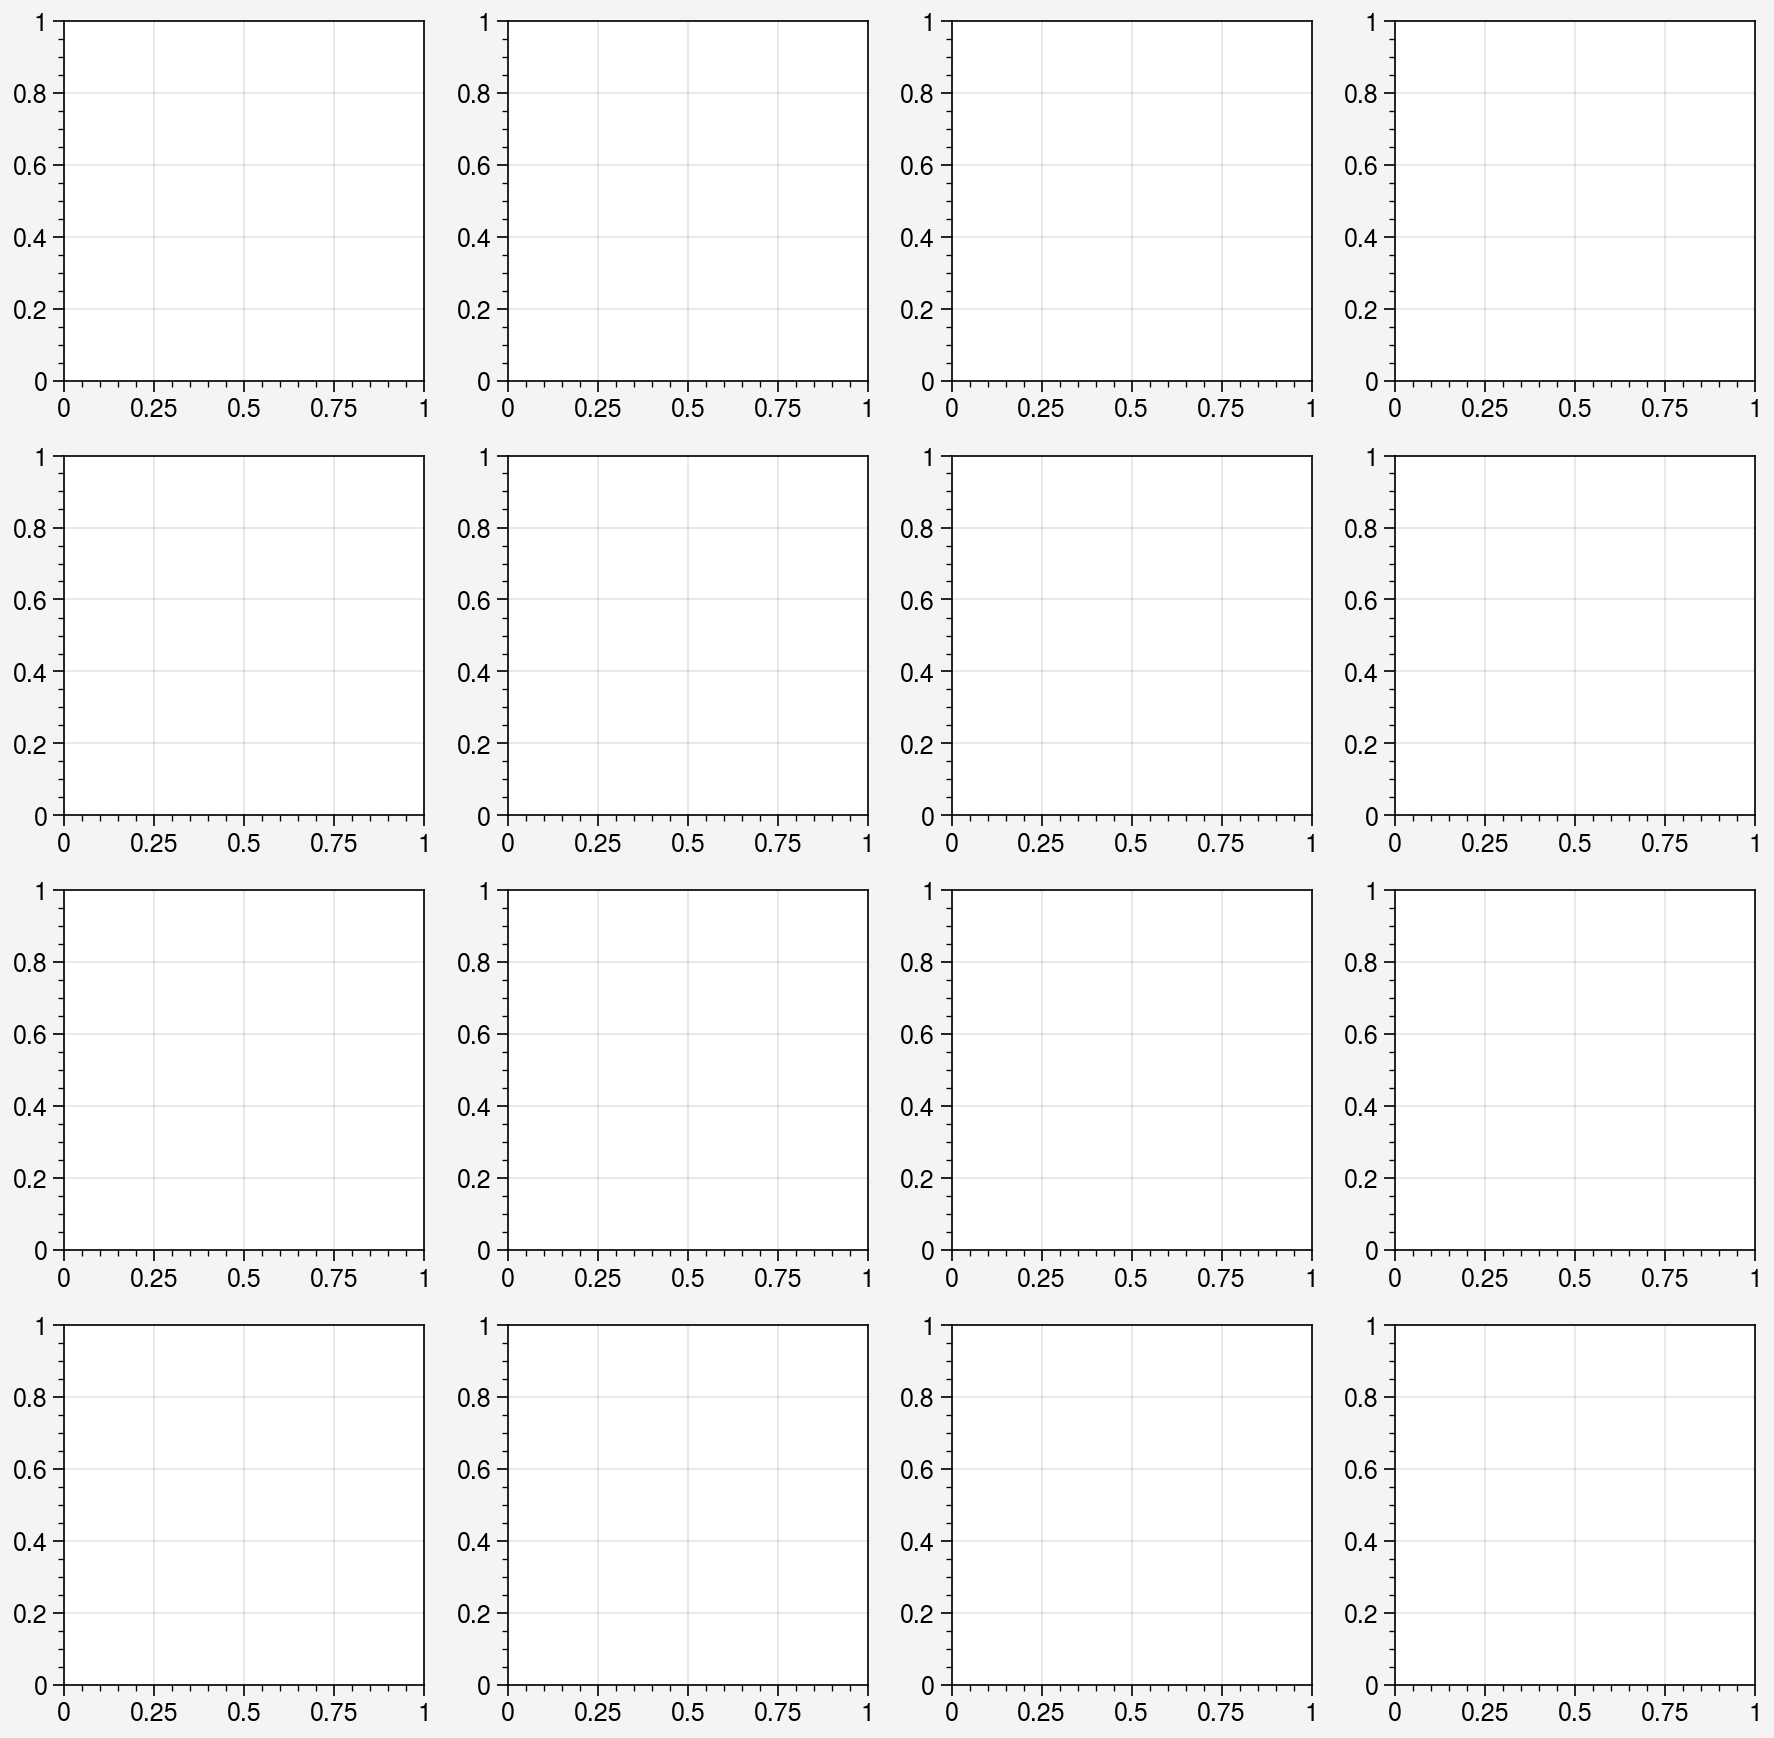

In [6]:
'''Plotting'''

variable = 'do18'
fig, axs = pplt.subplots(
        nrows=4, ncols=4, refwidth=1.8, panelpad=0.8,
        share=False,
    )

j = 0
for i in Erhardt_NGRIP_timing.index:
    event = Erhardt_NGRIP_timing['par'][i]
    NGRIP_data = pd.read_pickle('Data/NGRIP/'+str(variable)+'/'+str(event))
    if str(variable) == 'dO18':
        label = 'δ18O H2O [‰ SMOW]'
        obs_data = np.array(NGRIP_data[str(label)].values)
        obs_data = np.flip(obs_data)
        time = -1000 * np.flip(np.array(NGRIP_data['Age [ka BP]'].values))
        Y_ax_title = '$\delta ^{18} O$ / ‰'
    elif str(variable) == 'Ca':
        label = 'Ca2+ [ng/g]'
        obs_data = np.log(np.array(NGRIP_data[str(label)].values))
        obs_data = np.flip(obs_data)
        time = -1000 * np.flip(np.array(NGRIP_data['Age [ka BP]'].values))
        Y_ax_title = 'ln(Ca2+ [ng/g])'
    elif str(variable) == 'Na':
        label = 'Na+ [ng/g]'
        obs_data = np.log(np.array(NGRIP_data[str(label)].values))
        obs_data = np.flip(obs_data)
        time = -1000 * np.flip(np.array(NGRIP_data['Age [ka BP]'].values))
        Y_ax_title = 'ln(Na+ [ng/g])'
    elif str(variable) == 'Thickness':
        label = 'Thickness [m]'
        obs_data = np.log(np.array(NGRIP_data[str(label)].values))
        obs_data = np.flip(obs_data)
        time = -1000 * np.flip(np.array(NGRIP_data['Age [ka BP]'].values))
        Y_ax_title = 'ln(Thickness [m])'

    
    
    fig.format(fontsize = 14, xlabel = 'Kiloyears Before 1950', ylabel=Y_ax_title)
    ax = axs[j]
    
    cutoff_time = -Erhardt_NGRIP_timing['Age'][i] + float(Erhardt_NGRIP_timing[str(variable)][i])
    time = time[time<cutoff_time]
    obs_data = obs_data[:len(time)]
    reduced_time = np.abs(time)/1000
    result = stats.linregress(reduced_time,obs_data)

    ax.plot(reduced_time, obs_data, lw=0.5)
    ax.format(title=event)
    fit = result.intercept + reduced_time*result.slope
    if pvals[2,j] < 0.05:
        ax.plot(reduced_time, fit, color='k', lw=1.2, zorder=12)
    else:
        ax.plot(reduced_time, fit, color='k', lw=1.2, ls='--', zorder=12)

    j += 1

fig.show()